# Forecasting Product Demand

In this example, we will be forecasting the monthly demand of different products.  The data used is a public Kaggle dataset consisting of order demand per product and warehouse: [Product Demand Data](https://www.kaggle.com/felixzhao/productdemandforecasting).

We will be using Sparkling Water to ingest the data and add historical lags.

Our Machine Learning Workflow is: 

1. Import data into Spark
2. Exploratory Analysis
3. Feature engineering
   * Add time lag columns
4. Train a baseline model
5. Train model with lag features
6. Train model with additional features
7. Compare models
8. Shut down sparkling water cluster

# Step 1 (of 8).  Import data into Spark

In [1]:
# Initiate H2OContext on top of Spark

from pysparkling import *
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.16.2.48:54327... successful.


H2O cluster uptime:,11 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.2
H2O cluster version age:,1 month and 3 days
H2O cluster name:,sparkling-water-megankurka_app-20180719165539-0000
H2O cluster total nodes:,3
H2O cluster free memory:,2.210 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * H2O name: sparkling-water-megankurka_app-20180719165539-0000
 * cluster size: 3
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (2,172.16.2.48,54321)
  (0,172.16.2.48,54323)
  (1,172.16.2.48,54325)
  ------------------------

  Open H2O Flow in browser: http://172.16.2.48:54327 (CMD + click in Mac OSX)

    


In [2]:
# Import data

from pyspark.sql.types import *

schema = StructType([StructField("Product_Code", StringType(), True),
                     StructField("Warehouse", StringType(), True),
                     StructField("Product_Category", StringType(), True),
                     StructField("Month", DateType(), True),
                     StructField("Total_Demand", DoubleType(), True),
                     StructField("Number_Orders", DoubleType(), True)])

# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/time_series/product_demand/Monthly_Product_Demand.csv
products_df = spark.read.csv("../../data/topics/time_series/product_demand/Monthly_Product_Demand.csv", header = True, schema = schema)

In [3]:
products_df.show(5)

+------------+---------+----------------+----------+------------+-------------+
|Product_Code|Warehouse|Product_Category|     Month|Total_Demand|Number_Orders|
+------------+---------+----------------+----------+------------+-------------+
|Product_0001|   Whse_A|    Category_005|2012-01-01|      6400.0|          7.0|
|Product_0001|   Whse_A|    Category_005|2012-02-01|     10400.0|          5.0|
|Product_0001|   Whse_A|    Category_005|2012-03-01|     11000.0|          6.0|
|Product_0001|   Whse_A|    Category_005|2012-04-01|      1500.0|          2.0|
|Product_0001|   Whse_A|    Category_005|2012-05-01|      8000.0|          4.0|
+------------+---------+----------------+----------+------------+-------------+
only showing top 5 rows



# Step 2 (of 8).  Exploratory Analysis

We will start by exploring and analyzing our data.  We will first explore the data in PySpark and then do the same exploration in H2O. 

### PySpark Exploratory Analysis

In [4]:
# Data Schema
products_df.printSchema()

root
 |-- Product_Code: string (nullable = true)
 |-- Warehouse: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Month: date (nullable = true)
 |-- Total_Demand: double (nullable = true)
 |-- Number_Orders: double (nullable = true)



In [5]:
# Dimensions
print("Number of rows: ", "{:,}".format(products_df.count()))
print("Number of columns: ", "{:,}".format(len(products_df.columns)))

Number of rows:  160,750
Number of columns:  6


In [6]:
# Distinct Products
print("Number of Products: ", products_df.select("Product_Code").distinct().count())

Number of Products:  2160


In [7]:
# Distinct Warehouses
print("Number of Warehouses: ", products_df.select("Warehouse").distinct().count())

Number of Warehouses:  4


In [8]:
# Range of Demand
min_demand = products_df.agg({"Total_Demand": "min"}).collect()[0][0]
max_demand = products_df.agg({"Total_Demand": "max"}).collect()[0][0]
print("Demand Range: ", min_demand, " to ", max_demand)

Demand Range:  -447500.0  to  10450000.0


In [9]:
# Date Range
min_date = products_df.agg({"Month": "min"}).collect()[0][0]
max_date = products_df.agg({"Month": "max"}).collect()[0][0]
print("Date Range: ", min_date, " to ", max_date)

Date Range:  2011-01-01  to  2017-01-01


In [10]:
# Number of records per product and warehouse
from pyspark.sql.functions import count, col 
cnts = products_df.groupBy("Product_Code", "Product_Category", "Warehouse").agg(count("*").alias("cnt")).alias("cnts")
cnts.show()

+------------+----------------+---------+---+
|Product_Code|Product_Category|Warehouse|cnt|
+------------+----------------+---------+---+
|Product_0051|    Category_005|   Whse_J| 60|
|Product_0425|    Category_019|   Whse_A| 60|
|Product_0584|    Category_032|   Whse_J| 60|
|Product_0586|    Category_032|   Whse_J| 60|
|Product_0664|    Category_011|   Whse_J| 60|
|Product_0703|    Category_001|   Whse_J| 60|
|Product_0841|    Category_021|   Whse_J| 60|
|Product_1089|    Category_020|   Whse_S| 58|
|Product_1584|    Category_031|   Whse_A| 60|
|Product_1625|    Category_019|   Whse_J| 58|
|Product_1794|    Category_024|   Whse_S| 59|
|Product_1846|    Category_006|   Whse_S| 59|
|Product_1884|    Category_007|   Whse_J| 55|
|Product_2157|    Category_022|   Whse_S| 61|
|Product_0059|    Category_019|   Whse_J| 58|
|Product_0187|    Category_007|   Whse_J| 60|
|Product_0256|    Category_001|   Whse_J| 60|
|Product_0388|    Category_025|   Whse_S| 23|
|Product_0649|    Category_005|   

In [11]:
# Plot some of the time series data
plot_data = products_df.where((products_df.Product_Code == "Product_1846"))
plot_data.count()

179

In [12]:
plot_data = plot_data.toPandas()

In [13]:
plot_data.head()

,Product_Code,Warehouse,Product_Category,Month,Total_Demand,Number_Orders
0,Product_1846,Whse_A,Category_006,2012-01-01,10000.0,2.0
1,Product_1846,Whse_A,Category_006,2012-02-01,11000.0,4.0
2,Product_1846,Whse_A,Category_006,2012-03-01,0.0,0.0
3,Product_1846,Whse_A,Category_006,2012-04-01,10000.0,1.0
4,Product_1846,Whse_A,Category_006,2012-05-01,4000.0,3.0


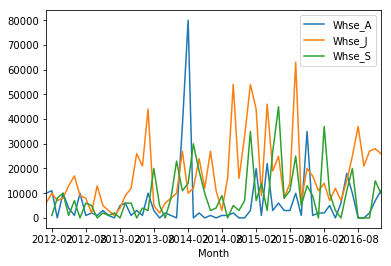

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1);
plot_data.groupby("Warehouse").plot(x="Month", y="Total_Demand", ax=ax);
plt.legend([v[0] for v in plot_data.groupby('Warehouse')['Warehouse']])

### H2O Exploratory Analysis

We will repeat the same exploratory analysis on the H2O Frame to show the differences in functionality.

In [15]:
## Convert Spark DataFrame to H2O Frame

import h2o
products_hf = hc.as_h2o_frame(products_df, "productsTable")

In [16]:
# Data Schema
products_hf.describe()

Rows:160750
Cols:6




,Product_Code,Warehouse,Product_Category,Month,Total_Demand,Number_Orders
type,string,string,string,time,int,int
mins,NaN,NaN,NaN,1293868800000.0,-447500.0,0.0
mean,NaN,NaN,NaN,1404129105249.1445,31750.247160186555,6.453101088646986
maxs,NaN,NaN,NaN,1483257600000.0,10450000.0,360.0
sigma,NaN,NaN,NaN,44903973191.3951,237129.89990964456,14.273056248626924
zeros,0,0,0,0,24909,24724
missing,0,0,0,0,0,0
0,Product_0001,Whse_A,Category_005,2012-01-01 08:00:00,6400.0,7.0
1,Product_0001,Whse_A,Category_005,2012-02-01 08:00:00,10400.0,5.0
2,Product_0001,Whse_A,Category_005,2012-03-01 08:00:00,11000.0,6.0


In [17]:
# Convert String to Categorical
cat_cols = ["Product_Code", "Product_Category", "Warehouse"]
for i in cat_cols:
    products_hf[i] = products_hf[i].asfactor()

In [18]:
# Dimensions
print("Number of rows: ", "{:,}".format(products_hf.nrow))
print("Number of columns: ", "{:,}".format(products_hf.ncol))

Number of rows:  160,750
Number of columns:  6


In [19]:
# Number of unique products
print("Number of Products: ", products_hf["Product_Code"].table().nrow)

Number of Products:  2160


In [20]:
# Number of unique warehouses
print("Number of Warehouses: ", products_hf["Warehouse"].table().nrow)

Number of Warehouses:  4


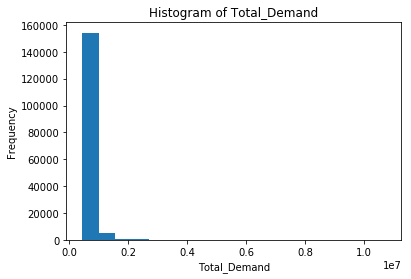

In [21]:
# Range of Demand
products_hf["Total_Demand"].hist()

In [22]:
# Date Range
print("Date Range")
products_hf = products_hf.sort("Month")
print(products_hf["Month"][[0, (products_hf.nrow - 1)], "Month"])

Date Range


Month
2011-01-01 08:00:00
2017-01-01 08:00:00


In [23]:
# Count per Product and Warehouse
print("Count per Product and Warehouse")
cnts = products_hf.group_by(["Product_Code", "Product_Category", "Warehouse"]).count().get_frame()
cnts.head()

Count per Product and Warehouse


Product_Code,Product_Category,Warehouse,nrow
Product_0001,Category_005,Whse_A,60
Product_0001,Category_005,Whse_J,61
Product_0002,Category_005,Whse_C,61
Product_0002,Category_005,Whse_S,61
Product_0003,Category_005,Whse_J,60
Product_0003,Category_005,Whse_S,58
Product_0004,Category_005,Whse_J,60
Product_0005,Category_005,Whse_J,54
Product_0006,Category_005,Whse_J,52
Product_0007,Category_005,Whse_J,60


# Step 3 (of 8).  Feature Engineering

We will add new features to our data that can help predict the Demand for a given product and warehouse.  Features that tell us:
* what was the Demand for a product and warehouse last month, two months ago, three months ago, etc?  
* what was the Number of Order for a product and warehouse last month?

can be very predictive in forecasting.  To create these features we will use PySpark's window function.

In [24]:
## Add Total Demand from the Previous month, Previous 2 months, Previous 3 months, etc per Product and Warehouse
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

w = Window().partitionBy([col(x) for x in ["Product_Code", "Product_Category", "Warehouse"]]).orderBy(col("Month"))
ext_products_df = products_df.select("*", lag("Total_Demand", count = 1).over(w).alias("Demand_lag1"),
                                     lag("Total_Demand", count = 2).over(w).alias("Demand_lag2"),
                                     lag("Total_Demand", count = 3).over(w).alias("Demand_lag3"),
                                     lag("Total_Demand", count = 4).over(w).alias("Demand_lag4"),
                                     lag("Total_Demand", count = 5).over(w).alias("Demand_lag5"),
                                     lag("Total_Demand", count = 6).over(w).alias("Demand_lag6"),
                                     lag("Total_Demand", count = 12).over(w).alias("Demand_lag12")).na.drop()

In [25]:
ext_products_df.show()

+------------+---------+----------------+----------+------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
|Product_Code|Warehouse|Product_Category|     Month|Total_Demand|Number_Orders|Demand_lag1|Demand_lag2|Demand_lag3|Demand_lag4|Demand_lag5|Demand_lag6|Demand_lag12|
+------------+---------+----------------+----------+------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
|Product_0051|   Whse_J|    Category_005|2013-01-01|      2000.0|          3.0|     4000.0|     3525.0|     2000.0|      575.0|     1000.0|     1500.0|      2000.0|
|Product_0051|   Whse_J|    Category_005|2013-02-01|      3500.0|          3.0|     2000.0|     4000.0|     3525.0|     2000.0|      575.0|     1000.0|      2525.0|
|Product_0051|   Whse_J|    Category_005|2013-03-01|      2525.0|          4.0|     3500.0|     2000.0|     4000.0|     3525.0|     2000.0|      575.0|      2000.0|
|Product_0

In [26]:
## Add Number of Orders for Previous month per Product and Warehouse

ext_products_df = ext_products_df.select("*", lag("Number_Orders", count = 1).over(w).alias("Number_Orders_lag1")).na.drop()

In [27]:
## Convert Spark DataFrame to H2O Frame
ext_products_hf = hc.as_h2o_frame(ext_products_df, "productsWithLagsTable")

In [28]:
# Convert String to Categorical
for i in cat_cols:
    ext_products_hf[i] = ext_products_hf[i].asfactor()

# Step 4 (of 8).  Train baseline model

We will begin our machine learning section by training a model using solely our original data.  We will use this model as a baseline to compare the performance of new models with additional features.

In [29]:
# Set Predictors
predictors = ["Product_Code", "Warehouse", "Product_Category"]
response = "Total_Demand"

In [30]:
# Split data into training and testing by time

train = ext_products_hf[ext_products_hf["Month"].year() < 2015]
test = ext_products_hf[ext_products_hf["Month"].year() == 2015]

In [31]:
# Train GBM Model with Early Stopping

from h2o.estimators import H2OGradientBoostingEstimator
baseline_model = H2OGradientBoostingEstimator(model_id = "baseline_model.hex",
                                              stopping_rounds = 3, stopping_metric = "MAE",
                                              score_tree_interval = 10, ntrees = 500)
baseline_model.train(x = predictors,
                     y = response,
                     training_frame = train,
                     validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


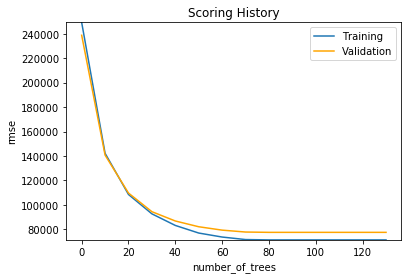

In [32]:
baseline_model.plot()

In [33]:
print("Baseline - MAE: " + "{:,}".format(round(baseline_model.mae(valid = True))))

Baseline - MAE: 14,524


# Step 5 (of 8).  Train model with lags

We will see if we can improve our model by adding our lag features as new predictors.

In [34]:
# Add Lag Predictors
ext_predictors = list(set(train.col_names) - set(["Total_Demand", "Number_Orders"]))
ext_predictors

['Warehouse',
 'Demand_lag4',
 'Number_Orders_lag1',
 'Month',
 'Product_Category',
 'Demand_lag12',
 'Product_Code',
 'Demand_lag5',
 'Demand_lag6',
 'Demand_lag2',
 'Demand_lag3',
 'Demand_lag1']

In [35]:
# Train GBM Model with Early Stopping

lag_features_v1 = H2OGradientBoostingEstimator(model_id = "lag_features_v1.hex",
                                              stopping_rounds = 3,  stopping_metric = "MAE",
                                              score_tree_interval = 10, ntrees = 500)
lag_features_v1.train(x = ext_predictors,
                      y = response,
                      training_frame = train,
                      validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


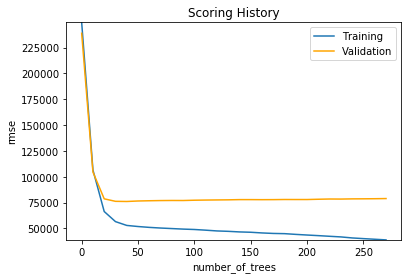

In [36]:
lag_features_v1.plot()

In [37]:
print("Baseline - MAE: " + "{:,}".format(round(baseline_model.mae(valid = True))))
print("Lag Features - MAE: " + "{:,}".format(round(lag_features_v1.mae(valid = True))))

Baseline - MAE: 14,524
Lag Features - MAE: 13,091


The graph below shows the variable importance for the gradient boosted model.  The most important predictors are the demand lags.  We can use the partial dependency plots to see the relationship between these features and the model's prediction.

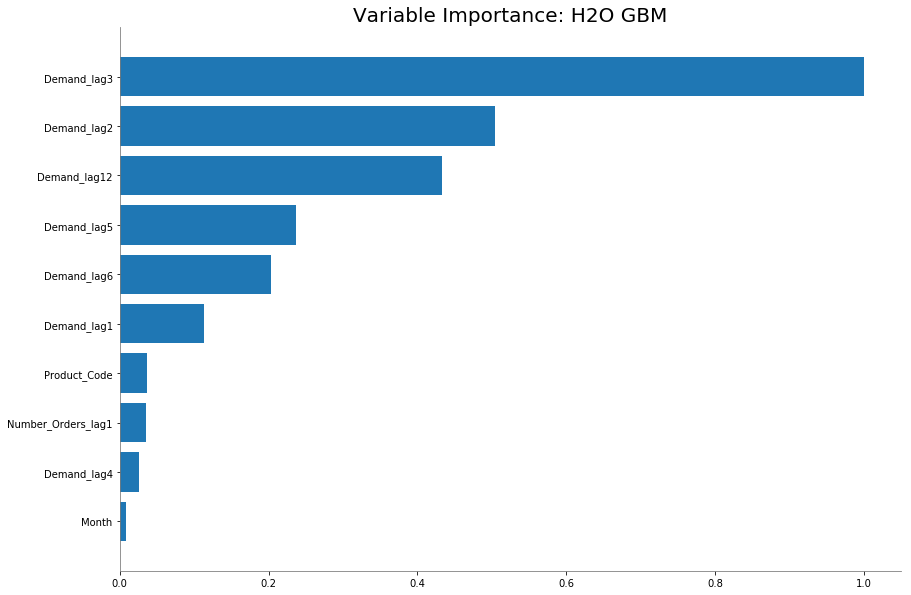

In [38]:
%matplotlib inline
lag_features_v1.varimp_plot(num_of_features = 10)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


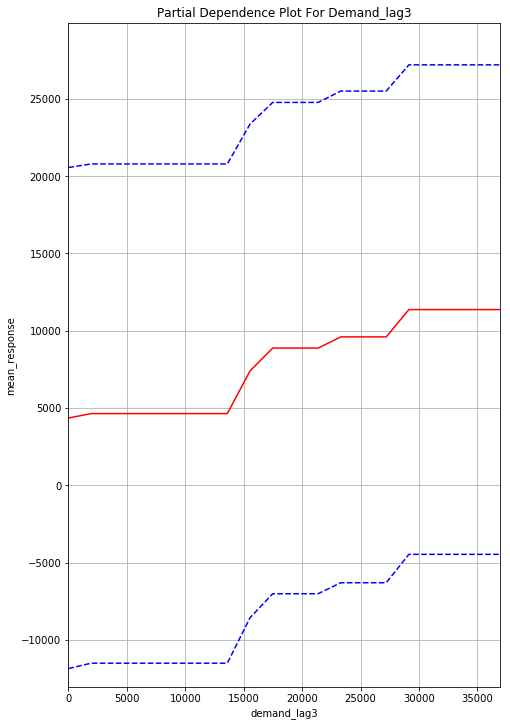

In [39]:
# Filter data to common demand
max_demand = train["Total_Demand"].quantile(prob = [0.9])[0, 1]
pdp_data = train[(train["Demand_lag3"] < max_demand) & (train["Demand_lag3"] >= 0)]
# create pdp's
pdps = lag_features_v1.partial_plot(data = pdp_data, cols = ["Demand_lag3"])

The partial plots show that the Demand from last quarter is related to the current month Demand.

# Step 6 (of 8).  Train Model with Additional Features

We will now use H2O to add additional features such as the change in demand over days.

A feature we would like to add is the average demand for product, warehouse, and product & warehouse.  Using the actual demand when calculating the average, however, can result in data leakage.  Instead we will calculate the average of the previous month's Demand.

In [40]:
# Average Demand Lag 1 by Product & Warehouse
avg_demand_group = ext_products_hf.group_by(["Product_Code", "Product_Category", "Warehouse"]).mean(["Demand_lag1"])
avg_demand_group = avg_demand_group.get_frame()
avg_demand_group.col_names = ["Product_Code", "Product_Category", "Warehouse", "mean_Demand_lag1_Product_Warehouse"]

In [41]:
avg_demand_group.head()

Product_Code,Product_Category,Warehouse,mean_Demand_lag1_Product_Warehouse
Product_0001,Category_005,Whse_A,5617.02
Product_0001,Category_005,Whse_J,1604.17
Product_0002,Category_005,Whse_C,2927.08
Product_0002,Category_005,Whse_S,150792
Product_0003,Category_005,Whse_J,1823.4
Product_0003,Category_005,Whse_S,344.444
Product_0004,Category_005,Whse_J,2474.47
Product_0005,Category_005,Whse_J,392.683
Product_0006,Category_005,Whse_J,133.333
Product_0007,Category_005,Whse_J,3342.55


In [42]:
# Average Demand Lag 1 by Warehouse
avg_demand_warehouse = ext_products_hf.group_by(["Warehouse"]).mean(["Demand_lag1"]).get_frame()
avg_demand_warehouse.col_names = ["Warehouse", "mean_Demand_lag1_Warehouse"]
avg_demand_warehouse.head()

Warehouse,mean_Demand_lag1_Warehouse
Whse_A,6173.64
Whse_C,43603.4
Whse_J,37219.7
Whse_S,36090.1


In [43]:
# Average Demand Lag 1 by Product
avg_demand_product = ext_products_hf.group_by(["Product_Code"]).mean(["Demand_lag1"]).get_frame()
avg_demand_product.col_names = ["Product_Code", "mean_Demand_lag1_Product"]
avg_demand_product.head()

Product_Code,mean_Demand_lag1_Product
Product_0001,3589.47
Product_0002,76859.4
Product_0003,1100
Product_0004,2474.47
Product_0005,392.683
Product_0006,133.333
Product_0007,3342.55
Product_0008,4218.09
Product_0009,782.979
Product_0010,1553.19


In [44]:
# Average Demand Lag 1 by Product Category
avg_demand_product_cat = ext_products_hf.group_by(["Product_Category"]).mean(["Demand_lag1"]).get_frame()
avg_demand_product_cat.col_names = ["Product_Category", "mean_Demand_lag1_ProductCat"]
avg_demand_product_cat.head()

Product_Category,mean_Demand_lag1_ProductCat
Category_001,102.99
Category_002,16.5238
Category_003,537.911
Category_004,1932.69
Category_005,15011.7
Category_006,51413
Category_007,11585.3
Category_008,37.7217
Category_009,522.301
Category_010,40.0836


In [45]:
# Merge averages to our original frame
ext_products_hf = ext_products_hf.merge(avg_demand_group, all_x = True, all_y = False)
ext_products_hf = ext_products_hf.merge(avg_demand_warehouse, all_x = True, all_y = False)
ext_products_hf = ext_products_hf.merge(avg_demand_product, all_x = True, all_y = False)
ext_products_hf = ext_products_hf.merge(avg_demand_product_cat, all_x = True, all_y = False)

In [46]:
ext_products_hf.head()

Product_Category,Product_Code,Warehouse,Month,Total_Demand,Number_Orders,Demand_lag1,Demand_lag2,Demand_lag3,Demand_lag4,Demand_lag5,Demand_lag6,Demand_lag12,Number_Orders_lag1,mean_Demand_lag1_Product_Warehouse,mean_Demand_lag1_Warehouse,mean_Demand_lag1_Product,mean_Demand_lag1_ProductCat
Category_001,Product_0256,Whse_J,2013-02-01 08:00:00,3,2,6,1,7,8,10,9,7,6,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-03-01 08:00:00,4,4,3,6,1,7,8,10,6,2,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-04-01 07:00:00,7,3,4,3,6,1,7,8,2,4,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-05-01 07:00:00,8,6,7,4,3,6,1,7,1,3,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-06-01 07:00:00,2,2,8,7,4,3,6,1,1,6,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-07-01 07:00:00,1,1,2,8,7,4,3,6,7,2,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-08-01 07:00:00,6,4,1,2,8,7,4,3,9,1,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-09-01 07:00:00,1,1,6,1,2,8,7,4,10,4,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-10-01 07:00:00,6,5,1,6,1,2,8,7,8,1,6.14894,37219.7,6.14894,102.99
Category_001,Product_0256,Whse_J,2013-11-01 07:00:00,7,5,6,1,6,1,2,8,7,5,6.14894,37219.7,6.14894,102.99


In [47]:
# Extract the month in case there is seasonality 
ext_products_hf["Categorical_Month"] = ext_products_hf["Month"].month().asfactor()
ext_products_hf["Categorical_Month"].table()

Categorical_Month,Count
1,8411
2,10109
3,10372
4,10473
5,10527
6,10561
7,10603
8,10627
9,10644
10,10656


In [48]:
# Add Lag Predictors
ext_predictors = list(set(ext_products_hf.col_names) - set(["Total_Demand", "Number_Orders"]))
ext_predictors

['Warehouse',
 'Demand_lag4',
 'Number_Orders_lag1',
 'Month',
 'Product_Category',
 'Demand_lag12',
 'Product_Code',
 'Demand_lag3',
 'Demand_lag1',
 'mean_Demand_lag1_Warehouse',
 'Categorical_Month',
 'mean_Demand_lag1_Product',
 'Demand_lag5',
 'Demand_lag6',
 'Demand_lag2',
 'mean_Demand_lag1_Product_Warehouse',
 'mean_Demand_lag1_ProductCat']

In [49]:
# Split data into training and testing by time

train = ext_products_hf[ext_products_hf["Month"].year() < 2015]
test = ext_products_hf[ext_products_hf["Month"].year() == 2015]

In [50]:
# Train GBM Model with Early Stopping

lag_features_v2 = H2OGradientBoostingEstimator(model_id = "lag_features_v2.hex",
                                              stopping_rounds = 3,  stopping_metric = "MAE",
                                              score_tree_interval = 10, ntrees = 500)
lag_features_v2.train(x = ext_predictors,
                      y = response,
                      training_frame = train,
                      validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Step 7 (of 8).  Compare Models

Below we compare our models by the Mean Absolute Error.

In [51]:
print("Baseline - MAE: " + "{:,}".format(round(baseline_model.mae(valid = True))))
print("Lag Features V1 - MAE: " + "{:,}".format(round(lag_features_v1.mae(valid = True))))
print("Lag Features V2 - MAE: " + "{:,}".format(round(lag_features_v2.mae(valid = True))))

Baseline - MAE: 14,524
Lag Features V1 - MAE: 13,091
Lag Features V2 - MAE: 12,386


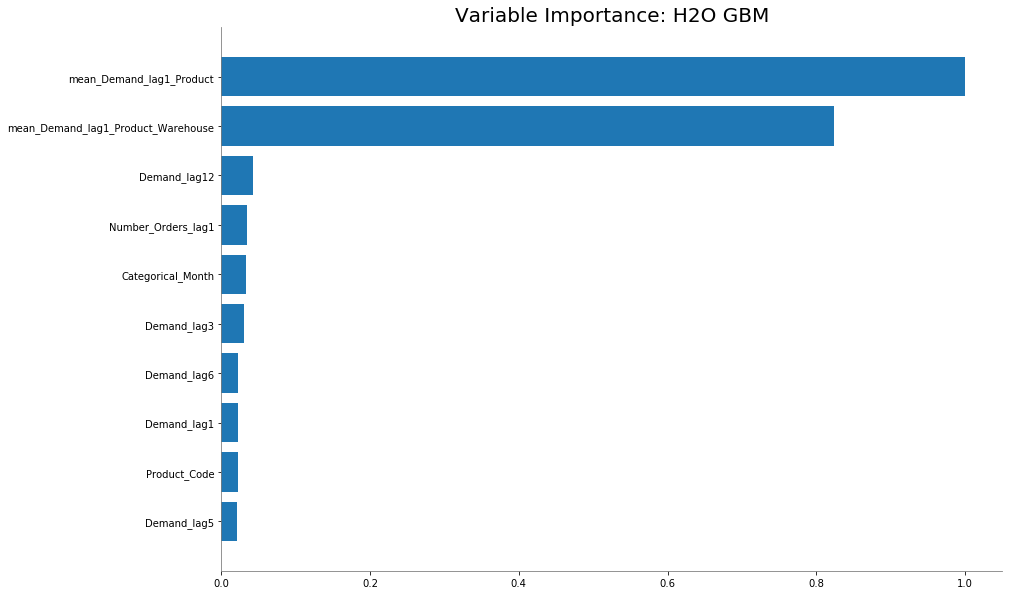

In [52]:
lag_features_v2.varimp_plot()

# Step 8 (of 8).  Shutdown the Sparkling Water Cluster

In [53]:
# Stop H2O and Spark services
h2o.cluster().shutdown()
spark.stop()

# Bonus: Github location for this tutorial

* https://github.com/h2oai/h2o-tutorials/tree/master/training/sparkling_water_hands_on/time_series